# Proposito del Proyecto

Trabajas como data sciense en Sweet Lift Taxi, una compañía que ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. La compañía necesita atraer a más conductores durante las horas pico, y nos ha pedido predecir la cantidad de pedidos de taxis para la próxima hora. **Construye un modelo para dicha predicción.**

A Sweet Lift Taxi le interesa:

-  El RECM en el conjunto de prueba no debe ser superior a 48.

Para llevar a cabo este proyecto necesitaremos: 

1. Descargar los datos y hacer el remuestreo por una hora.
2. Analizar los datos.
3. Entrenar diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Probar los datos usando la muestra de prueba y proporciona una conclusión.

## Inicialización

In [1]:
#Instalamos las librerías necesarias
!pip install LightGBM
!pip install CatBoost
!pip install XGBoost
!pip install prophet

In [2]:
#Importamos las librerias necesarias 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate=False
logger.setLevel(logging.CRITICAL)

### Cargar datos

In [3]:
try:
    df= pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

### Explorar datos iniciales

**Características**

- *datetime — fecha y hora en la que se pidió el taxi*

**Objetivo**
- *num_orders — El número de pedidos*

Revisaremos la información general para observar: valores nulos, tipos de datos, nombres de las columnas, con el fin de encontrar posibles errores que tengamos que tratar

In [4]:
#Observamos nuestro df
df.head(10)

datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32
5  2018-03-01 00:50:00          21
6  2018-03-01 01:00:00           7
7  2018-03-01 01:10:00           5
8  2018-03-01 01:20:00          17
9  2018-03-01 01:30:00          12

In [5]:
#Revisamos sus dimensiones
df.shape

(26496, 2)

In [6]:
#Revisamos la informacion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
#Busamos valores nulos
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [8]:
#Buscamos valores duplicados
df.duplicated().sum()

0

Observamos que nuestro dataset tiene los siguientes problemas a resolver:
1. Necesitamos convertir los datos a un formato conveniente, seleccionar el periodo para el análisis.
2. Establecer el índice de la tabla igual a la columna datetime.
3. Verificar si las fechas y horas están en orden cronológico.
4. Ordenar el índice de la tabla.

Luego de esto podremos realizar el remuestreo por hora.

### Visualización de datos

Observaremos las distribución de nuestra característica

In [9]:
df.describe()

num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

<AxesSubplot:title={'center':'Número de pedidos'}, ylabel='Frequency'>

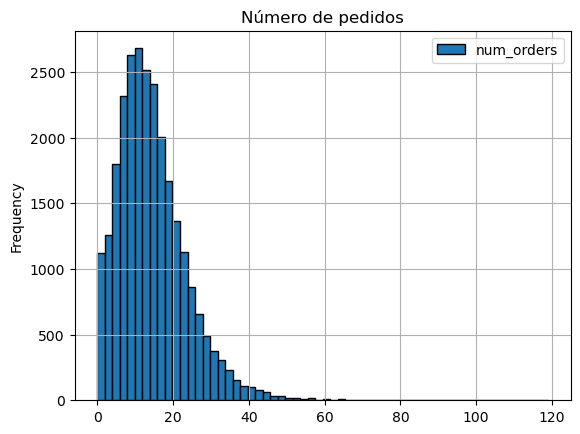

In [10]:
df.plot(kind='hist', title= 'Número de pedidos', bins=60, edgecolor= 'black', grid=True)

Observamos en nustro histograma y en nuestra distribución de datos que el promedio de taxis pedidos es de 14 , siendo el promedio mayor que la mediana, por lo que podemos ver una asimetría positiva, es decir, nuestro histograma sesgado a la derecha para un periodo de tiempo de diez minutos. 

## Preparación de datos

Observamos que para poder trabajar con nuestros datos y hacer análisis con series temporales debemos realizar las modificaciones que nos permitan realizar un mejor análisis.

### Cargar datos para series temporales

In [11]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/car_data.csv', index_col=[0], parse_dates=[0])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Observamos datos en un periodo de tiempo de Marzo del 2018 hasta Agosto del 2018. 

### Verificar orden cronológico

In [13]:
df.sort_index(inplace=True)
df.index.is_monotonic

True

Nuestros datos presentan orden cronológico.

### Remuestreo por hora

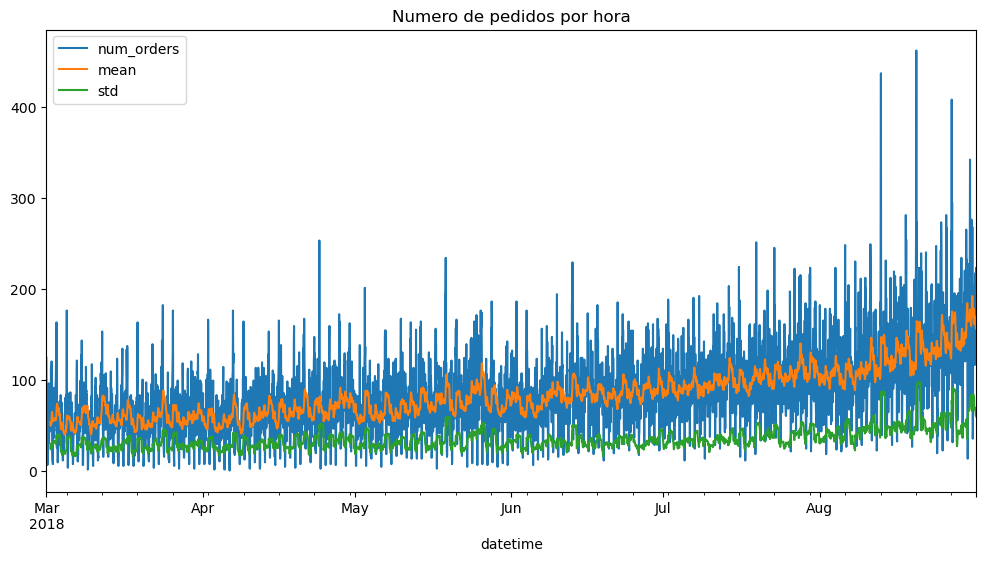

In [14]:
df_h= df.resample('1H').sum()
rolling_mean = df_h['num_orders'].rolling(20).mean()
rolling_std= df_h['num_orders'].rolling(20).std()
#Trazamos un gráfico de lineas

df_h.plot(figsize=(12,6), title= 'Numero de pedidos por hora')
rolling_mean.plot()
rolling_std.plot()
plt.legend(['num_orders', 'mean', 'std'])
plt.show()

In [15]:
df = df_h.copy()

In [16]:
df.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

Observamos que la media presenta un aumento de forma muy ligera a partir del mes de **Mayo** mostrando los valores mas altos en el mes de **Abril**. Se puede ver el comportamiento lineal de la media en ascenso, por lo que podriamos decir que estamos frente a un comportamiento estocastico **no estacionario**.
Onservamos nuestra distribución de datos, que corresponde con lo analizado anteriormente ya que un promedio de 14 pedidos por un tiempo de 10 minutos, llevado a una hora sería igual a 84 pedidos por hora. 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Tendencia y estacionalidad

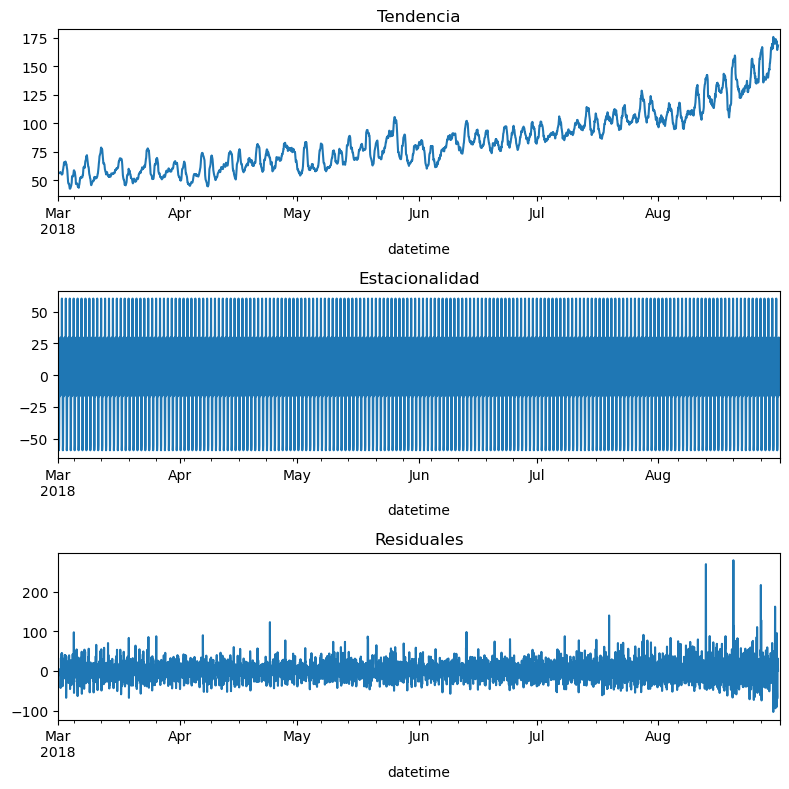

In [18]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')
#Encajamos los graficos
plt.tight_layout()
plt.show()

- Gráfico 1 : Muestra la tendencia y como vemos variaciones en la media y la desviación estandar, nuestra serie temporal presenta un proceso estocástico no estaionario. Observamos que efectivamente la tendencia marcada por el cambio de la media se presenta en los periodos de tiempo **Mayo-Agosto**, este suceso puede explicarse por el horario de verano, si bien comienza en Junio es normal pensar que hay personas que anticipen algunas vacaciones, y por lo tanto mayor demanda de taxis hacia los aeropuertos. 
- Gráfico 2: Muestra la estacionalidad, y que no logramos observar nada por el lapso de tiempo tan corto, podriamos llevarlo a días para tratar de observar alguna estacionalidad.
- Gráfico 3 :  Nos muestra el error de la serie, para este caso, los valores extremos de -100 y +200 en los residuos podrían indicar la presencia de valores atípicos. Estas son observaciones inusuales que difieren significativamente del patrón general de los datos. 

### Remuestreo por día

Haremos un remuestreo por día para ver si podemos observar algun patrón en la estacionalidad

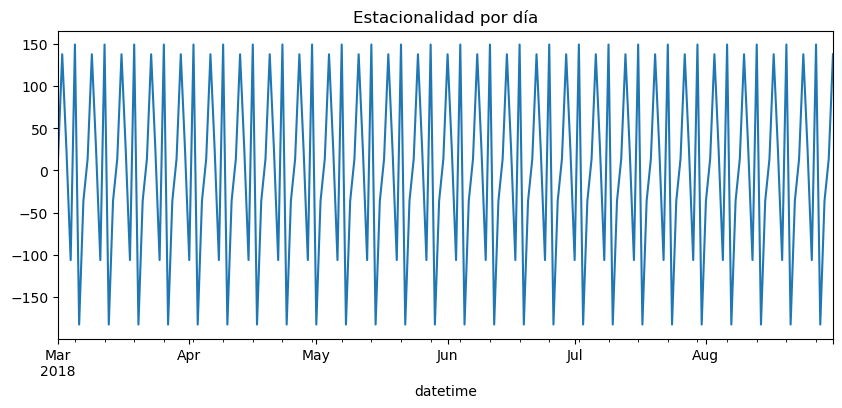

In [19]:
df_day = df.resample('1D').sum()

decomposed_d = seasonal_decompose(df_day)
plt.figure(figsize=(10, 4))
decomposed_d.seasonal.plot()
plt.title('Estacionalidad por día')
plt.show()

Hemos encontrado una estacionalidad en nuestro remuestreo por día, conseguimos por mes entre 8 y 9 picos, podemos estudiar el comportamiento semanal para ver que pasa con estos picos, revisemos el mes de Junio, que es donde vemos el cambio de estación.

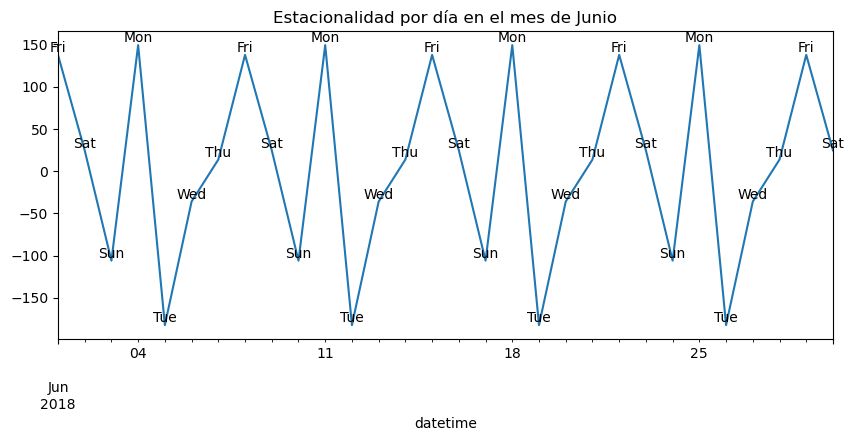

In [20]:
plt.figure(figsize=(10, 4))
segmento = decomposed_d.seasonal['2018-06']
segmento.plot(ax=plt.gca())
plt.title('Estacionalidad por día en el mes de Junio')

# Agregar los días de la semana en el gráfico
for fecha, valor in segmento.iteritems():
    dia_semana = fecha.day_name()[:3]  # Obtener el día de la semana en formato abreviado (por ejemplo, "Mon")
    plt.text(fecha, valor, dia_semana, ha='center', va='bottom')

plt.show()

- Observamos que los picos son dos veces por semana, exactamente para los lunes y los viernes, que coinciden con el inicio de fin de semana y el inicio de la semana laboral.
- Entendemos tambien porque algunos meses presentan 8 y otros 9 picos, dependiento del número de días correspondiente al mes.

Analizaremos la tendencia y estacionalidad en un periodo de cuatro días, para ver en en que horas se presenta la mayor demanda de taxis, hasta ahora sabemos que meses y que días tienen mayor demanda, trabajaremos con nuestro df remuestreado por horas en un periodo de cuatro días en el mes de Junio, tomaremos del primero al cuatro (que contempla los días mas demandados)

Text(0.5, 1.0, 'Estacionalidad por hora entre el 01 y 02 de Junio')

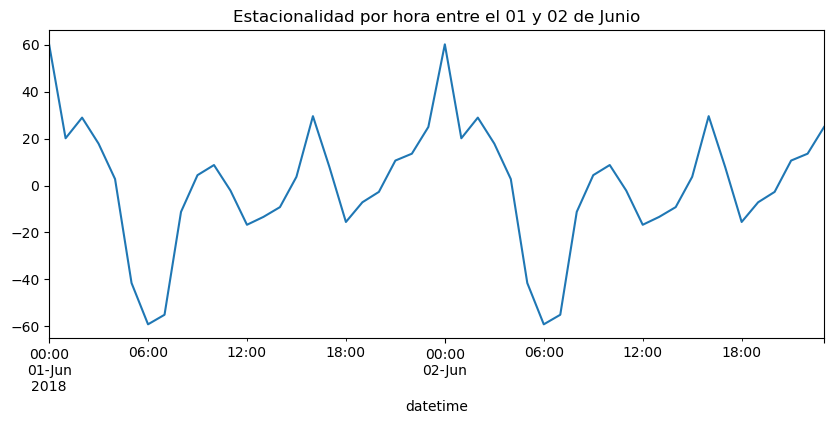

In [21]:
plt.figure(figsize=(10, 4))
segmento = decomposed.seasonal['2018-06-01':'2018-06-02']
segmento.plot(ax=plt.gca())
plt.title('Estacionalidad por hora entre el 01 y 02 de Junio')

- Podemos observar que tenemos tres picos en horas similares en un día con alta demanda y en otro con poca demanda.
- Los picos son a las 00:00 , al rededor de las 10:00 y cerca de las 17:00 horas. 

### Prueba de estacionariedad

Una de las formas de detectar la estacionariedad es gráficarla e inferir el comportamiento de esta. La ventaja que este método es rápido, sin embargo, se encuentra sesgado por el criterio del ojo humano. En nuestro caso, podemos inferir en nuestro remuestreo por hora que la media y desviación estandar muestran variación es decir no es estacionaria.

Completaremos este análisis con estadística, usaremos la prueba Dickey-Fuller, esta prueba la hipótesis nula de que una raíz unitaria está presente en un modelo autorregresivo. La hipótesis alternativa es diferente según la versión de la prueba utilizada, pero generalmente es estacionariedad o tendencia-estacionaria. 

Para efectos práticos, para el caso de estacionariedad se puede definir el test como:

- Hipótesis Nula $H_0$: la serie temporal no es estacionaria.
- Hipótesis Alternativa $H_1$: la serie temporal es alternativa.

Rechazar la hipótesis nula (es decir, un valor p muy bajo) indicará estacionariedad, usaremos un nivel de significancia del 5%.

In [22]:
print ('Resultados del test de Dickey-Fuller:')
#test Dickey-Fulle:
dftest = adfuller(df['num_orders'])
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Resultados del test de Dickey-Fuller:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64


Según los resultados del test de Dickey-Fuller, el valor del estadístico de prueba (Test Statistic) es -3.068924 y el valor p (p-value) es 0.028940. En este caso, el valor p (0.028940) es menor que 0.05, lo que sugiere que hay evidencia estadística para rechazar la hipótesis nula y concluir que la serie de tiempo es estacionaria.

*Se creía que nuestra serie temporal no presentaba estacionariedad, pero el test estadístico indicó lo contrario esto puede suceder por los siguientes escenarios*

- Sensibilidad del test: El test de Dickey-Fuller se basa en ciertas suposiciones y puede tener limitaciones en su capacidad para detectar cambios sutiles o patrones complejos en los datos. A veces, incluso si la serie de tiempo muestra aparentemente un aumento de media, el test puede indicar estacionariedad debido a su enfoque en otros aspectos de la serie (como la presencia de tendencia o estacionalidad).

- Ruido o variabilidad en los datos: Aunque pueda haber un aumento aparente en la media al final del gráfico, es posible que sea el resultado de fluctuaciones aleatorias o variabilidad en los datos. Estas fluctuaciones pueden ocultar la presencia de una verdadera tendencia o patrón.

## Entrenamiento de modelos

Para predecir el número de pedidos de taxis entrenaremos varios modelos.
Entrenaremos y compararemos modelos de árbol de decisión, bosque aleatorio y regresión lineal junto con los de potenciación de gradiente: LightGBM, CateBoost y XGBoost.

**Creación de características**

Agregaremos características relevantes a nuestro df de series de tiempo, como año, mes, día, día de la semana y hora así como características de desfase donde los valores anteriores en la serie temporal nos dirán si el número de pedidos aumentará o disminuirá, junto con una media movil para observar la tendencia general.

In [23]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (df['num_orders'].shift().rolling(rolling_mean_size).mean())
    return df

In [24]:
#Aplicamos la función 
make_features(df, 7,4)
df.head()

num_orders  year  month  day  dayofweek  hour  lag_1  \
datetime                                                                    
2018-03-01 00:00:00         124  2018      3    1          3     0    NaN   
2018-03-01 01:00:00          85  2018      3    1          3     1  124.0   
2018-03-01 02:00:00          71  2018      3    1          3     2   85.0   
2018-03-01 03:00:00          66  2018      3    1          3     3   71.0   
2018-03-01 04:00:00          43  2018      3    1          3     4   66.0   

                     lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  rolling_mean  
datetime                                                                     
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN           NaN  
2018-03-01 02:00:00  124.0    NaN    NaN    NaN    NaN    NaN           NaN  
2018-03-01 03:00:00   85.0  124.0    NaN    NaN    NaN    NaN           NaN  
2018-03-01 04:00:00   71.0   85.0  124.0    NaN    NaN    NaN          86.5

In [25]:
#Eliminamos los valores nulos obtenidos por el desfase
df.dropna(inplace=True)
df.head()

num_orders  year  month  day  dayofweek  hour  lag_1  \
datetime                                                                    
2018-03-01 07:00:00          15  2018      3    1          3     7   12.0   
2018-03-01 08:00:00          34  2018      3    1          3     8   15.0   
2018-03-01 09:00:00          69  2018      3    1          3     9   34.0   
2018-03-01 10:00:00          64  2018      3    1          3    10   69.0   
2018-03-01 11:00:00          96  2018      3    1          3    11   64.0   

                     lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  rolling_mean  
datetime                                                                     
2018-03-01 07:00:00    6.0   43.0   66.0   71.0   85.0  124.0         31.75  
2018-03-01 08:00:00   12.0    6.0   43.0   66.0   71.0   85.0         19.00  
2018-03-01 09:00:00   15.0   12.0    6.0   43.0   66.0   71.0         16.75  
2018-03-01 10:00:00   34.0   15.0   12.0    6.0   43.0   66.0         32.50  
2018-03-01 11:00:00   69.0   34.0   15.0   12.0    6.0   43.0         45.50

**División de conjuntos**

In [26]:
#Dividimos los datos con shuffle=False
train, test = train_test_split(df, shuffle=False, test_size=0.1)
#Comprobamos que este correcto
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 07:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [27]:
#Establacemos las características y el conjunto de entrenamiento
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test= test['num_orders']

**Prueba de cordura**

In [28]:
#Obtenemos las predicciones que seran iguales a los valores anteriores
pred_previous = target_test.shift()
#Establecemos el ultimo valor de entrenamiento como el primero de la serie de prueba
pred_previous.iloc[0] = target_train.iloc[-1]
#Calculamos el RECM
RECM_cord= mean_squared_error(target_test, pred_previous) ** 0.5
print(f'RECM:{RECM_cord}',)

RECM:58.91761802963282


**Función para hiperparámetros**

In [29]:
def gscv_model (estimator_name, params, x_train, y_train):
    
    gridsearch = GridSearchCV(
    estimator=estimator_name,
    param_grid=params,
    scoring= 'neg_root_mean_squared_error',
    cv=tscv
)
    gridsearch.fit(x_train, y_train)
    
    max_score = gridsearch.cv_results_['mean_test_score'].max()
    index_max_score = np.where(gridsearch.cv_results_['mean_test_score']== max_score)[0][0]
    best_set_of_params = gridsearch.cv_results_['params'][index_max_score]
    
    return best_set_of_params, -(max_score)

Usaremos TimeSeriesSplit ya que respeta el orden temporal de los datos al realizar la división. En lugar de dividir los datos en partes aleatorias, divide los datos en secuencias temporales. Cada secuencia temporal incluye datos pasados en el conjunto de entrenamiento y datos futuros en el conjunto de prueba, lo que refleja la forma en que se utilizaría el modelo en una situación de predicción real.

In [30]:
#Definiremos un TimeSeriesSplit que dividira nuestra validación cruzada de forma continua
tscv = TimeSeriesSplit(n_splits=5)

### Regresión Lineal

Como el modelo de Regresión Lineal no tiene optimización por hiperparámetros, lo entrenaremos y evaluaremos en el conjunto de prueba.

In [31]:
#Entrenamos el modelo de regresión lineal
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
pred_train = lr_model.predict(features_train)
#Hacemos las predicciones para el conjunto de prueba
pred_test = lr_model.predict(features_test)
RECM_lr = mean_squared_error(target_test, pred_test)** 0.5

print(f'RECM Regresion Lineal:{RECM_lr}')

RECM Regresion Lineal:52.73988481092026


### Árbol de decisión

**Ajuste de hiperparámetros**

In [32]:
#Establecemos los hiperparámetros
params_dt = {
    'max_depth': [2,3,4,5,6,7],
    'min_samples_split' : [2,4,6,8,10],
    'min_samples_leaf' : [2,4,6,8]
}

#Llamamos a la función gscv
best_params_dt, best_score_dt = gscv_model(DecisionTreeRegressor(), params_dt, features_train, target_train)

#Imprimimos los resultados
print(f'Mejores hiperparámetros: {best_params_dt} | Mejor RECM: {best_score_dt:.3f}')

Mejores hiperparámetros: {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 6} | Mejor RECM: 29.310


In [33]:
#Entrenamos nuestro modelo con los mejores hiperparámetros
dt_model = DecisionTreeRegressor(random_state=12345, max_depth=7, min_samples_split=4, min_samples_leaf=8)
dt_model.fit(features_train, target_train)
#Realizamos predicciones
pred_dt= dt_model.predict(features_test)

#Calculamos el RECM
RECM_dt = mean_squared_error(target_test, pred_dt)** 0.5
print(f'RECM Árbol de decisión: {RECM_dt:.3f}')


RECM Árbol de decisión: 49.108


### Bosque Aleatorio

**Ajuste de hiperparámetros**

In [34]:
#Establecemos los hiperparámetros
params_rf = {
    'n_estimators': [20,40,60],
    'max_depth' : [4,6,8,10,12]
}

#Llamamos a la función gscv
best_params_rf, best_score_rf = gscv_model(RandomForestRegressor(), params_rf, features_train, target_train)

#Imprimimos los resultados
print(f'Mejores hiperparámetros: {best_params_rf} | Mejor RECM: {best_score_rf:.3f}')

Mejores hiperparámetros: {'max_depth': 12, 'n_estimators': 60} | Mejor RECM: 25.608


In [35]:
#Entrenamos nuestro modelo con los mejores hiperparámetros
rf_model = RandomForestRegressor(random_state=12345, max_depth=12, n_estimators=60)
rf_model.fit(features_train, target_train)
#Realizamos predicciones
pred_rf= rf_model.predict(features_test)

#Calculamos el RECM
RECM_rf = mean_squared_error(target_test, pred_rf)** 0.5
print(f'RECM Bosque Aleatorio: {RECM_rf:.3f}')


RECM Bosque Aleatorio: 44.488


### LightGBM

**Ajuste de hiperparámetros**

In [36]:
params_gbm = {
    'n_estimators': [100,300],
    'learning_rate': [0.1 , 0.2, 0.5],
    'num_leaves': [10,20]
}
    
#Llamamos a la función gscv
best_params_gbm, best_score_gbm = gscv_model(LGBMRegressor(), params_gbm, features_train, target_train)

#Imprimimos los resultados
print(f'Mejores hiperparámetros: {best_params_gbm} | Mejor RECM: {best_score_gbm:.3f}') 

Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 10} | Mejor RECM: 25.165


In [37]:
#Entrenamos nuestro modelo con los mejores hiperparámetros
gbm_model = LGBMRegressor(random_state=12345, num_leaves=10, n_estimators=100, learning_rate=0.1)
gbm_model.fit(features_train, target_train)
#Realizamos predicciones
pred_gbm= gbm_model.predict(features_test)

#Calculamos el RECM
RECM_gbm = mean_squared_error(target_test, pred_gbm)** 0.5
print(f'RECM LightGBM: {RECM_gbm:.3f}')


RECM LightGBM: 44.604


### CatBoost

**Ajuste de hiperparámetros**

In [38]:
#Establecemos los hiperparámetros
params_cb = {
    'depth': [4,6,10],
    'learning_rate': [0.1 , 0.2, 0.5],
    'iterations':[100],
    'verbose':[False],
    'loss_function': ['RMSE']
}
#Llamamos a la función gscv
best_params_cb, best_score_cb = gscv_model(CatBoostRegressor(), params_cb, features_train, target_train)

#Imprimimos los resultados
print(f'Mejores hiperparámetros: {best_params_cb} | Mejor RECM: {best_score_cb:.3f}') 

Mejores hiperparámetros: {'depth': 4, 'iterations': 100, 'learning_rate': 0.2, 'loss_function': 'RMSE', 'verbose': False} | Mejor RECM: 25.254


In [39]:
#Entrenamos nuestro modelo con los mejores hiperparámetros
cb_model = CatBoostRegressor(random_state=12345, depth=4, iterations=100, learning_rate=0.2, loss_function='RMSE', verbose=False)
cb_model.fit(features_train, target_train)
#Realizamos predicciones
pred_cb= cb_model.predict(features_test)

#Calculamos el RECM
RECM_cb = mean_squared_error(target_test, pred_cb)** 0.5
print(f'RECM CatBoost: {RECM_cb:.3f}')

RECM CatBoost: 44.943


### XGBoost

**Ajuste de hiperparámetros**

In [40]:
#Establecemos los hiperparámetros
params_xgb = {
    'max_depth': [2, 4, 6],
    'n_estimators': [20, 50],
    'learning_rate': [0.05, 0.1],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 1, 10]
}
best_params_xgb, best_score_xgb = gscv_model(XGBRegressor(), params_xgb, features_train, target_train)

#Imprimimos los resultados
print(f'Mejores hiperparámetros: {best_params_xgb} | Mejor RECM: {best_score_xgb:.3f}') 

Mejores hiperparámetros: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'reg_lambda': 0.1} | Mejor RECM: 25.587


In [41]:
#Entrenamos nuestro modelo con los mejores hiperparámetros
xgb_model = XGBRegressor(random_state=12345, gamma=1, n_estimators=50, learning_rate=0.1, max_depth=6, reg_lambda=0.1)
xgb_model.fit(features_train, target_train)
#Realizamos predicciones
pred_xgb= xgb_model.predict(features_test)

#Calculamos el RECM
RECM_xgb = mean_squared_error(target_test, pred_xgb)** 0.5
print(f'RECM XGBoost: {RECM_xgb:.3f}')

RECM XGBoost: 44.286


### Prophet

Prophet es un procedimiento para pronosticar datos de series temporales basado en un modelo aditivo en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos.

In [42]:
#filtramos el dataset original
prophet = df_h['num_orders'].reset_index()
prophet.columns = ['ds', 'y']
prophet.head()

ds    y
0 2018-03-01 00:00:00  124
1 2018-03-01 01:00:00   85
2 2018-03-01 02:00:00   71
3 2018-03-01 03:00:00   66
4 2018-03-01 04:00:00   43

In [43]:
# Dividimos el conjunto de datos
train_prophet, test_prophet = train_test_split(prophet, shuffle=False, test_size=0.1)
#Comprobamos la cronologia
print(train_prophet['ds'].min(), train_prophet['ds'].max())
print(test_prophet['ds'].min(), test_prophet['ds'].max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


**Ajustamos los hiperparámetros**

In [44]:
param_grid={
    'changepoint_prior_scale': [0.001, 0.01 , 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}
#Generamos todas las combinaciones
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses= []

for params in all_params:
    m= Prophet(**params).fit(train_prophet)
    df_cv = cross_validation(m, horizon= '795 hours', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    
tuning_results = pd.DataFrame(all_params)
tuning_results['rmses'] = rmses

tuning_results.sort_values(['rmses'])


changepoint_prior_scale  seasonality_prior_scale      rmses
14                    0.500                     1.00  29.422895
13                    0.500                     0.10  29.436155
15                    0.500                    10.00  29.444771
12                    0.500                     0.01  29.609615
9                     0.100                     0.10  29.640523
11                    0.100                    10.00  29.659927
10                    0.100                     1.00  29.670979
8                     0.100                     0.01  29.757587
5                     0.010                     0.10  30.133583
7                     0.010                    10.00  30.171554
6                     0.010                     1.00  30.174095
4                     0.010                     0.01  30.260827
2                     0.001                     1.00  30.495871
1                     0.001                     0.10  30.592645
3                     0.001                    10.00  30.738679
0                     0.001                     0.01  31.071017

In [45]:
#Establecemos los mejores parametros
best_params_prophet = all_params[np.argmin(rmses)]
best_score_prophet = rmses[np.argmin(rmses)]
print(f'Mejores hiperparametros:{best_params_prophet}, Mejor RECM: {best_score_prophet}')

Mejores hiperparametros:{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}, Mejor RECM: 29.42289495778955


In [46]:
#Aplicamos los hiperparametros
m = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale= 0.5, seasonality_prior_scale=1.0)
#Entrenamos el modelo
m.fit(train_prophet)
#Realizamos predicciones
predict= m.predict(test_prophet)
#Imprimimos las predicciones
predict.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2018-08-13 14:00:00  116.133153   86.190844  146.095581   116.133153   
1 2018-08-13 15:00:00  116.159965  106.266693  169.747410   116.159965   
2 2018-08-13 16:00:00  116.186776  114.411520  173.663364   116.186776   
3 2018-08-13 17:00:00  116.213587   98.715674  160.306553   116.213587   
4 2018-08-13 18:00:00  116.240398   79.539046  139.508167   116.240398   

   trend_upper     daily  daily_lower  daily_upper  multiplicative_terms  \
0   116.133153 -0.070838    -0.070838    -0.070838             -0.005212   
1   116.159965  0.136611     0.136611     0.136611              0.190634   
2   116.186776  0.213578     0.213578     0.213578              0.255226   
3   116.213587  0.104007     0.104007     0.104007              0.132647   
4   116.240398 -0.078825    -0.078825    -0.078825             -0.063683   

   multiplicative_terms_lower  multiplicative_terms_upper    weekly  \
0                   -0.005212                   -0.005212  0.065625   
1                    0.190634                    0.190634  0.054023   
2                    0.255226                    0.255226  0.041648   
3                    0.132647                    0.132647  0.028639   
4                   -0.063683                   -0.063683  0.015142   

   weekly_lower  weekly_upper  additive_terms  additive_terms_lower  \
0      0.065625      0.065625             0.0                   0.0   
1      0.054023      0.054023             0.0                   0.0   
2      0.041648      0.041648             0.0                   0.0   
3      0.028639      0.028639             0.0                   0.0   
4      0.015142      0.015142             0.0                   0.0   

   additive_terms_upper        yhat  
0                   0.0  115.527839  
1                   0.0  138.304039  
2                   0.0  145.840715  
3                   0.0  131.628943  
4                   0.0  108.837850

In [47]:
#Obtenemos el RECM
RECM_prophet = mean_squared_error(y_true=test_prophet['y'], y_pred=predict['yhat'])**0.5
print(f'RECM Prophet:{RECM_prophet}')

RECM Prophet:44.14893324966927


### Conclusión de los modelos 

Crearemos una tabla con todos los RECM obtenidos para hacer una mejor comparación

In [48]:
models = pd.DataFrame({
    'modelo': ['Prueba de Cordura', 'Regresion Lineal', 'Arbol de decision', 'Bosque Aleatorio', 'LightGBM', 'CatBoost', 'XGBoost', 'Prophet'],
    'RECM' : [RECM_cord, RECM_lr, RECM_dt, RECM_rf, RECM_gbm, RECM_cb,RECM_xgb, RECM_prophet]
})

models

modelo       RECM
0  Prueba de Cordura  58.917618
1   Regresion Lineal  52.739885
2  Arbol de decision  49.108215
3   Bosque Aleatorio  44.488458
4           LightGBM  44.603828
5           CatBoost  44.942942
6            XGBoost  44.286453
7            Prophet  44.148933

Observamos en nuestros modelos lo siguiente:
- Se entrenaron 7 modelos, de los cuales todos pasaron el RECM minimo solicitado, excepto el modelo de Árbol de decisión.
- Los modelos con mejores métricas fueron LightGBM con un RECM: 43.95  y Prophet con un RECM: 44.14
- De los modelos mejor Prophet es el que presento menos sobreajuste.


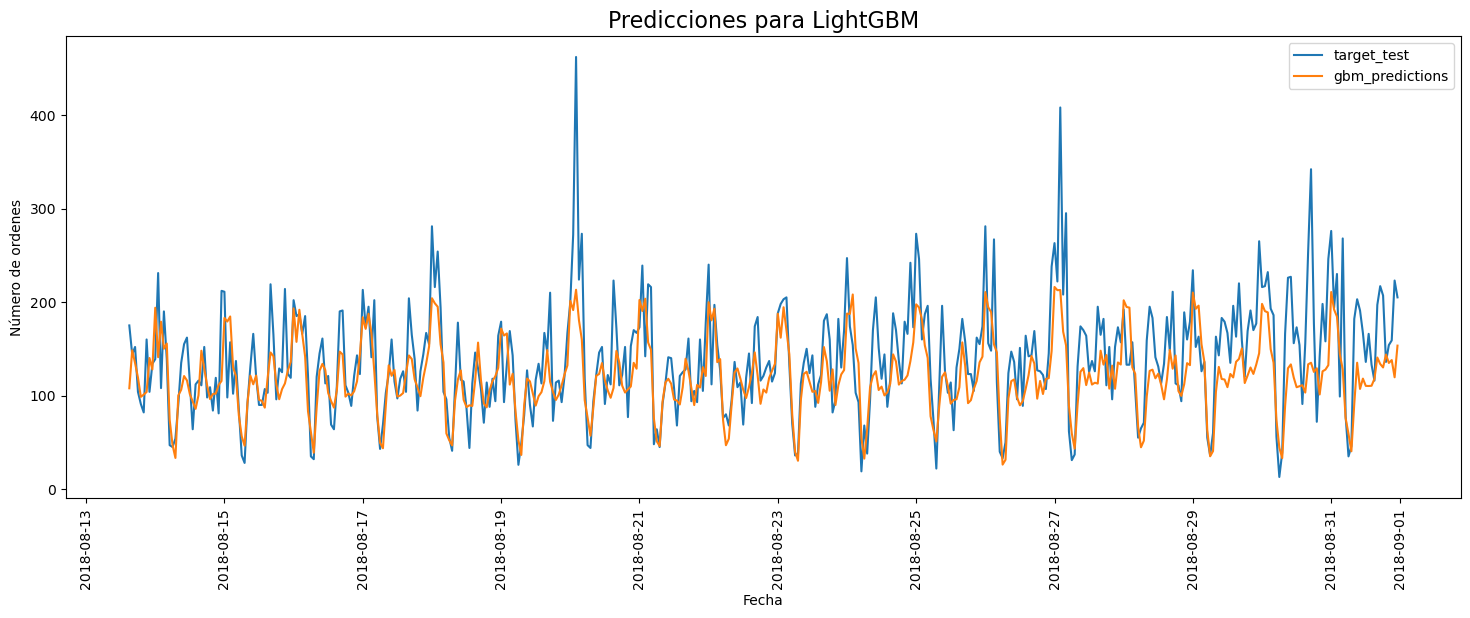

In [49]:
plt.figure(figsize=(18,6))
gbm = pd.Series(pred_gbm, index=target_test.index)
plt.plot(target_test, label='target_test')
plt.plot(gbm, label='gbm_predictions')
plt.title('Predicciones para LightGBM', fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Fecha')
plt.ylabel('Número de ordenes')
plt.legend()
plt.show()

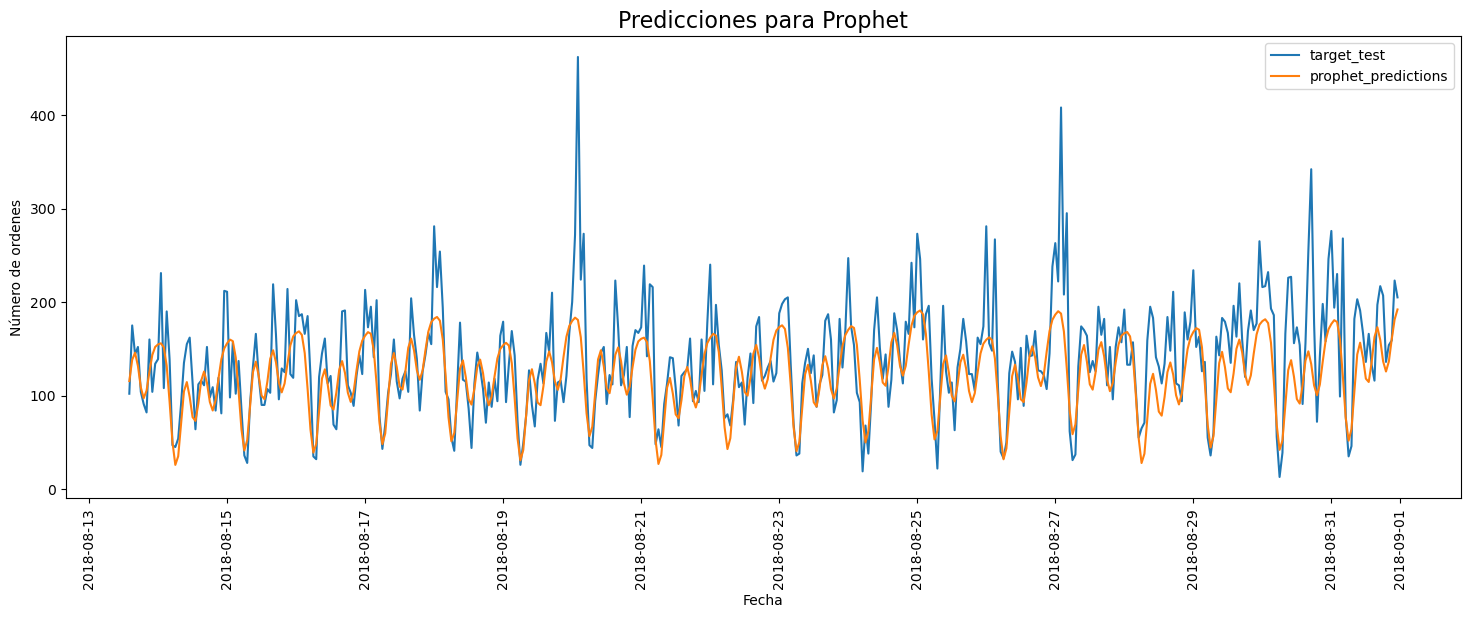

In [50]:
plt.figure(figsize=(18,6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='target_test')
plt.plot(test_prophet['ds'], predict['yhat'], label='prophet_predictions')
plt.title('Predicciones para Prophet', fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Fecha')
plt.ylabel('Número de ordenes')
plt.legend()
plt.show()

Podemos observar como nuestros dos mejores modelos predicen de forma muy similar siguiendo los patrones de estacionalidad, debemos resaltar que:
- El modelo de LightGBM tiene mejores predicciones, lo podemos ver porque sus picos estan más cercanos a los valores reales.
- Ambos modelos no logran hacer predicciones de los días de la demanda sobrepasa los 200 pedidos. 

# Conclusión

**Procesamiento de datos**
- No se encontraron valores duplicados, ni valores nulos.
- Fue necesario realizar modificaciones en los datos para trabajar las series temporales:
    - Cambiar el tipo de datos y usarlo como indice.
    - Se hizo un remuestreo por hora.
    - Se hizo un remuestreo por dia.
    
**Remuestreo por hora**

Observamos un aumento de pedidos en los meses Mayo-Agosto, observamos como la media mostró variación en este lapso de tiempo. Lo relacionamos a la poca de vecaciones este incremento en la tendencia. En este marco de tiempo no se obervo estacionalidad.

**Remuestreo por dia**

Observamos en nuestro remuestreo por día un comportamiento estacional, los días con más demandas son los lunes y los viernes. Tambien se observaron picos repetitvos por mes.

Al encontrar estacionalidad por día decidimos usar nuestro remuestreo por hora en un marco de tiempo de dos día, esto nos dejo un patrón de incrementos de pedidos en los siguiente horarios 00:00, 10:00 y 17:00 (aproximadamente).

**Modelos**

Los modelos con mejores métricas fueron:
    - LightGBM = Su RECM fue el mejor, con 43.95, aunque para este modelo se necesitaron crear características y observamos un fuerte sobreajuste.
    - Prophet = Su RECM fue de 44.14, aunque este modelo no tuvo la mejor métrica, este no necesito la creación de características , es un modelo que funciona para series temporales sin realizar muchos ajustes, y el sobreajuste que presenta  fue menor que LighGBM.
    
La empresa Sweet Lift Taxi esta buscando solo el mejor valor RECM, por lo que le recomendamos usar el modelo LightGBM.


